# Chit-Chat: Making Sense of My Class Conversations  

## Project Overview  
This project is me turning my own class’s **Google Meet chats** into a full-blown NLP playground.  
We talk a lot; sometimes about data, sometimes about life, sometimes about memes that shouldn’t exist.  
I figured: *why not analyze it?*  

The idea is simple: **take raw chat transcripts → turn them into structured data → apply NLP + analytics → uncover patterns about how we talk, what we talk about, and when we talk the most.**  

Think of it as: *quantifying chaos*.  

## Data  
- Source: Class standup session chat exports (Tuesday → Thursday).  
- Format: .sbv subtitle-like files → parsed into a dataframe with:  
  - timestamp`  
  - name`  
  - text`  
  - day`  
  - start_time / end_time  
  - hours_in_class (so I can track talkativeness across the session)  

## What I’m Doing  

### 1. **Exploration**  
- Word frequencies & n-grams --> who says what, and how often.  
- TF-IDF --> unique vocab per student or day.  
- Engagement timelines --> when does the energy peak? Are we more talkative in hour 1 vs hour 2?  

### 2. **Topic Modeling**  
- Using LDA / BERTopic to see the hidden themes.  
- Expect clusters like:  
  - *“dataset troubleshooting”*  
  - *“presentation anxiety”*  
  - *“inside jokes no one outside class will get”*  

### 3. **Clustering & Embeddings**  
- Sentence embeddings + KMeans to group similar chats.  
- See which convos naturally cluster together (questions, banter, actual work 👀).  

### 4. **Sentiment & Emotion**  
- Track the mood of the class: are we positive, stressed, neutral?  
- Emotion tagging (joy, frustration, confusion) to see how feelings flow during the session.  

### 5. **Speaker Analysis**  
- Who talks the most?  
- Who introduces new topics vs who mostly reacts?  
- Basically: who drives the vibe of the class.  

### 6. **Recommender Angle**  
- Build a “study buddy” recommender system based on similarity of chats.  
- If you sound like me in class, the algo might just recommend we team up.  

### 7. **Advanced Fun**  
- **Dialogue Act Classification** --> label lines as *Question / Answer / Joke / Instruction / Off-topic*.  
- **Keyword Extraction** --> daily highlights without re-reading everything.  
- **Summarization** --> generate auto “standup recaps.”  
- **Network Analysis** --> build a social graph of who responds to who (aka, our class dynamics in one picture).    

## Tech Stack  
- **Pandas** for wrangling  
- **NLTK / SpaCy** for preprocessing  
- **Scikit-learn** for TF-IDF, clustering, and classification  
- **BERTopic / Gensim** for topic modeling  
- **NetworkX** for social graph analysis  
- **Matplotlib / Seaborn / Plotly** for making the chaos look pretty  

## Expected Insights  
- Are we more talkative at the start, midway, or near the end?  
- What do we actually talk about (vs what we *think* we talk about)?  
- Who dominates conversations, and who stays quiet?  
- Can we auto-summarize our standups without losing context?  

Import all relevant libraries

In [50]:
# Utilities
import warnings
warnings.filterwarnings('ignore')

# Mathematical Operations
import numpy as np

# Data Manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')
import seaborn as sns

# Install wordcloud in environment
#!pip install wordcloud

# Use Wordcloud
from wordcloud import WordCloud, STOPWORDS

# String manipulation
import re

from IPython.display import display

# NLP
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from scipy.cluster.hierarchy import dendrogram, ward
from sklearn.neighbors import NearestNeighbors

# SVD
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import svds

# Clustering metric scores
from sklearn.metrics import silhouette_score
from sklearn import metrics

# Statistics & Scientific Computing
from scipy.stats import randint

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, normalize

# Machine Learning - Model Selection & Evaluation
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc,
    roc_auc_score,
    balanced_accuracy_score,
    f1_score
)

# Show entire column contents
pd.set_option('display.max_colwidth', None)

In [51]:
# Get stopwords from NLTK
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
# # Check the english stopwords
# print(stopwords.words('english'))

# # Check Swahili stopwords
# #print(stopwords.words('kiswahili'))

### Step 1: Read All Chat Files & Inspect Structure  

The data comes in .sbv (subtitle) format.  
Unlike CSVs, these files don’t have predefined columns. Instead, they contain timestamp ranges and chat text blocks.  

Before any preprocessing, I’ll load each file and peek at the raw structure to understand how the timestamps and messages are formatted.   


In [53]:
# Load Tuesday's chats
tuesday_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_09_30 08_33 EAT - Chat 2.sbv"

with open(tuesday_path, "r", encoding="utf-8-sig") as f:
    tuesday_lines = f.readlines()

tuesday_lines[:20]  # peek at structure

['00:01:15.122,00:01:18.122\n',
 'William Arasirwa: lakini i need lessons on presentation\n',
 '\n',
 '00:10:39.341,00:10:42.341\n',
 'Stanley Njihia: Mnaskia reverb wakubwa\n',
 '\n',
 '00:10:47.810,00:10:50.810\n',
 'William Arasirwa: eeeeh\n',
 '\n',
 '00:14:14.814,00:14:17.814\n',
 'Stanley Njihia: Peris, cheza na massgrave io watermark iko apo bottom right iache kukusumbua.\n',
 '\n',
 '00:15:11.823,00:15:14.823\n',
 'William Arasirwa: address the elephant in the room\n',
 '\n',
 '00:15:43.275,00:15:46.275\n',
 'William Arasirwa: watu wa car dataset tuliona vumb\n',
 '\n',
 '00:16:02.430,00:16:05.430\n',
 'Stanley Njihia: ptsd\n']

In [54]:
# Load Wednesday's chats
wenno_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_10_01 08_31 EAT - Chat.sbv"

with open(wenno_path, "r", encoding="utf-8-sig") as f:
    wenno_lines = f.readlines()

wenno_lines[:20]  # peek at structure

['00:00:06.928,00:00:09.928\n',
 'Ann-Felicity Mureithi: mnijibu\n',
 '\n',
 '00:00:10.928,00:00:13.928\n',
 'Norman Mwapea: Skia sentiments za gen alpha\n',
 '\n',
 '00:00:41.309,00:00:44.309\n',
 'Norman Mwapea: Kuhustle ka sjakosea. Ama ni aje Judith\n',
 '\n',
 '00:01:05.563,00:01:08.563\n',
 'Ann-Felicity Mureithi: @ stan wewe ebu confrim\n',
 '\n',
 '00:02:00.671,00:02:03.671\n',
 'Ann-Felicity Mureithi: aws\n',
 '\n',
 '00:02:22.962,00:02:25.962\n',
 'Norman Mwapea: Ati what tool did you use apart from gpt. That was just nasty\n',
 '\n',
 '00:10:30.379,00:10:33.379\n',
 'Ann-Felicity Mureithi: google search\n']

In [55]:
# Load Thursday's chats
thur_path = r"C:\Users\lenovo\OneDrive\Desktop\DS\PROJECTS\chit-chat\Chatter box\DSF-FT13R_P4_Standup - 2025_10_02 08_32 EAT - Chat.sbv"

with open(thur_path, "r", encoding="utf-8-sig") as f:
    thur_lines = f.readlines()

thur_lines[:20]  # peek at structure

['00:00:00.075,00:00:03.075\n',
 'Norman Mwapea: Story inabamba sindio\n',
 '\n',
 '00:00:17.119,00:00:20.119\n',
 'Norman Mwapea: Mucene ya asubuhi. Morning gloru\n',
 '\n',
 '00:01:36.531,00:01:39.531\n',
 'Huldah Rotich: Kitts wa part time take a longer time so hatuwezi graduate na hao\n',
 '\n',
 '00:02:09.736,00:02:12.736\n',
 'Stanley Njihia: Vile ii mambo inaendelea itabidi Kitts ametolewa frontlines\n',
 '\n',
 '00:02:40.130,00:02:43.130\n',
 'William Arasirwa: ken ?\n',
 '\n',
 '00:02:43.832,00:02:46.832\n',
 'Jeff Kandie: Ken walibor\n',
 '\n',
 '00:02:48.896,00:02:51.896\n',
 'Jeff Kandie: a\n']

### Step 2: Convert SBV Chat Files into DataFrames  

SBV files are cool but messy. They’re built for subtitles, not data analysis.  
And honestly, working directly with them feels clunky.  

For that reason, I'll parse them into pandas DataFrames- something more farmiliar and easier to work with.  
Once the chats are sitting neatly in DataFrames (with proper columns), I can finally treat them like actual data: filter, group, analyze, and visualize without breaking a sweat.  

In [56]:
# Parse the corpus and convert them into dataframes
def sbv_to_dataframe(file_path):
    
    '''Function to convert each file into a dataframe for easier analysis'''

    with open(file_path, "r", encoding="utf-8-sig") as f:
        content = f.read().strip()
    
    # Split by double newlines (each block = 1 subtitle)
    blocks = content.split("\n\n")
    
    data = []
    for block in blocks:
        lines = block.strip().split("\n")
        if len(lines) >= 2:
            timestamp = lines[0].strip()
            line_text = lines[1].strip()
            
            # Split into name + text if ":" exists
            if ":" in line_text:
                name, text = line_text.split(":", 1)
                name, text = name.strip(), text.strip()
            else:
                name, text = None, line_text  # fallback if no name
            
            data.append([timestamp, name, text])
    
    return pd.DataFrame(data, columns=["timestamp", "name", "text"])

In [57]:
# Convert files into dataframes
tuesday_df = sbv_to_dataframe(tuesday_path)
wenno_df   = sbv_to_dataframe(wenno_path)
thur_df    = sbv_to_dataframe(thur_path)

# Load the corpus as dataframes

print("Tuesday:")
display(tuesday_df.sample(7))

print("Wednesday:")
display(wenno_df.sample(7))

print("Thursday:")
display(thur_df.sample(7))

Tuesday:


,timestamp,name,text
181,"01:36:50.146,01:36:53.146",Jeff Mogaka,ju ni haikuwork
117,"01:22:12.844,01:22:15.844",Alvin kipleting,"@ jeff sidhani comeback itamake ,nani huyo amesema jeff anatumia roll on"
127,"01:23:41.896,01:23:44.896",William Arasirwa,juu zinakaa chupa ya lotion sio
168,"01:34:13.510,01:34:16.510",Alvin kipleting,@ jeff venye unakuwa battered is a good example of how villains are made
254,"01:51:17.269,01:51:20.269",Fridah Njung'e,not sure...phase 0 tm said that
145,"01:25:38.579,01:25:41.579",Jeff Mogaka,wueeeeh
231,"01:47:18.647,01:47:21.647",Jeff Mogaka,zii jiulize kwann Ngaire sikuhizi ako humble


Wednesday:


,timestamp,name,text
16,"00:39:06.076,00:39:09.076",Jeff Mogaka,@arasirwa unasema wewe hubag shawries ni bag gani hii unatumia
122,"01:55:13.319,01:55:16.319",Maureen Ngaire,Ata siwezi jump into conclusions
244,"02:42:36.023,02:42:39.023",Ann-Felicity Mureithi,@ Jeff unataka nije kwako pia
80,"01:47:38.195,01:47:41.195",Maureen Ngaire,Njihia huwezi fanyia boiz wako ivo. That's very cold
227,"02:32:41.083,02:32:44.083",William Arasirwa,you can do better ama you are also short on thoughts?
61,"01:34:10.077,01:34:13.077",William Arasirwa,na hii akili ya jeff
12,"00:38:28.788,00:38:31.788",Kitts Kikumu,money


Thursday:


,timestamp,name,text
109,"01:02:35.927,01:02:38.927",Ann-Felicity Mureithi,arasirwa mimi nina method yangu
138,"01:31:33.399,01:31:36.399",Kitts Kikumu,"i mean it should, kumbuka tulikuwa twajaribu 123 na 42 we found 42 was better"
114,"01:09:26.801,01:09:29.801",Kitts Kikumu,unajipiga own goal
58,"00:39:06.253,00:39:09.253",Kitts Kikumu,norman huwa watumia collab mostly?
95,"00:57:34.373,00:57:37.373",Maureen Ngaire,nmepata asanti
210,"02:13:58.876,02:14:01.876",Stanley Njihia,Umesema kumuamini ndio ilikua shida?
193,"02:05:26.109,02:05:29.109",William Arasirwa,@kitts that msemo doesn't apply to jeff


### Step 3: Combine All DataFrames into One Consolidated Dataset  

Each chat file represents a different lesson for a different day.  
To analyze the class as a whole, I need everything in one consistent dataset.  

By stacking the DataFrames together and tagging them with their respective day, I’ll have a single, unified view of the conversations across all sessions.  
This makes it easier to spot patterns; like how discussions shift day to day or which sessions are the most active.  

In [58]:
# Assign class dates
tuesday_df["date"] = pd.to_datetime("2025-09-30")
wenno_df["date"]   = pd.to_datetime("2025-10-01")
thur_df["date"]    = pd.to_datetime("2025-10-02")

# Combine all dataframes into one
chat_df = pd.concat([tuesday_df, wenno_df, thur_df], ignore_index=True)

# Extract start & end from timestamp
def _extract_start_end(ts):
    """Extract time ranges (hh:mm:ss) from timestamp string"""
    if pd.isna(ts):
        return (None, None)

    s = str(ts).strip()

    if "," in s: 
        left, right = [p.strip() for p in s.split(",", 1)]
        return (left or None, right or None)

    matches = re.findall(r"\d{1,2}:\d{2}:\d{2}(?:\.\d+)?", s)
    if len(matches) >= 2:
        return (matches[0], matches[1])
    if len(matches) == 1:
        return (matches[0], None)

    return (None, None)

# Apply extraction
times = chat_df["timestamp"].apply(_extract_start_end)
chat_df[["start_time_raw", "end_time_raw"]] = pd.DataFrame(times.tolist(), index=chat_df.index)

# Convert to timedelta
chat_df["start_time_td"] = pd.to_timedelta(chat_df["start_time_raw"], errors="coerce")
chat_df["end_time_td"]   = pd.to_timedelta(chat_df["end_time_raw"], errors="coerce")

# Create hours in class (numeric)
chat_df["hours_in_class"] = chat_df["start_time_td"].dt.total_seconds() / 3600.0

# Create human-readable hh:mm:ss strings (Option 1)
chat_df["start_time"] = chat_df["start_time_td"].dt.components.apply(
    lambda x: f"{int(x.hours):02}:{int(x.minutes):02}:{int(x.seconds):02}", axis=1
)
chat_df["end_time"] = chat_df["end_time_td"].dt.components.apply(
    lambda x: f"{int(x.hours):02}:{int(x.minutes):02}:{int(x.seconds):02}", axis=1
)

# Add a day column
chat_df["day"] = chat_df["date"].dt.day_name()

# Final tidy dataframe
chatterbox_df = chat_df[[
    "timestamp", "name", "text", "day", 
    "start_time", "end_time", "hours_in_class"
]].copy()

# Normalize text
chatterbox_df['text'] = chatterbox_df['text'].str.lower()

# Preview
display(chatterbox_df)


,timestamp,name,text,day,start_time,end_time,hours_in_class
0,"00:01:15.122,00:01:18.122",William Arasirwa,lakini i need lessons on presentation,Tuesday,00:01:15,00:01:18,0.020867
1,"00:10:39.341,00:10:42.341",Stanley Njihia,mnaskia reverb wakubwa,Tuesday,00:10:39,00:10:42,0.177595
2,"00:10:47.810,00:10:50.810",William Arasirwa,eeeeh,Tuesday,00:10:47,00:10:50,0.179947
3,"00:14:14.814,00:14:17.814",Stanley Njihia,"peris, cheza na massgrave io watermark iko apo bottom right iache kukusumbua.",Tuesday,00:14:14,00:14:17,0.237448
4,"00:15:11.823,00:15:14.823",William Arasirwa,address the elephant in the room,Tuesday,00:15:11,00:15:14,0.253284
...,...,...,...,...,...,...,...
741,"02:16:58.724,02:17:01.724",Alvin kipleting,inakata tu naisha,Thursday,02:16:58,02:17:01,2.282979
742,"02:18:27.329,02:18:30.329",Kitts Kikumu,two months in two days,Thursday,02:18:27,02:18:30,2.307591
743,"02:18:30.920,02:18:33.920",Nesphory Mwadime,enyewe moringa ni business,Thursday,02:18:30,02:18:33,2.308589
744,"02:18:43.093,02:18:46.093",Stanley Njihia,eeiyy,Thursday,02:18:43,02:18:46,2.311970


### Step 4: Data Understanding  

Thasswassuh!  
Now that the dataset is complete and consistent, it’s time to get to know it.  

I’ll start by exploring the basics:  
- Previewing rows and columns  
- Checking metadata (data types, missing values, distributions)  
- Assessing overall quality  

This step sets the stage for deeper analysis; making sure the data is clean, structured, and ready for all the fun stuff that comes next.  

#### Check the dataset's shape.

In [59]:
# Check the dataset's shape
print(f"The chat has {chatterbox_df.shape[0]} records and {chatterbox_df.shape[1]} columns.")

The chat has 746 records and 7 columns.


#### Column names check

In [60]:
# Columns
chatterbox_df.columns

Index(['timestamp', 'name', 'text', 'day', 'start_time', 'end_time',
       'hours_in_class'],
      dtype='object')

*Observation:* Column names are consistent.

#### Get metadata

In [61]:
# Get data information
chatterbox_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   timestamp       746 non-null    object 
 1   name            746 non-null    object 
 2   text            746 non-null    object 
 3   day             746 non-null    object 
 4   start_time      746 non-null    object 
 5   end_time        746 non-null    object 
 6   hours_in_class  746 non-null    float64
dtypes: float64(1), object(6)
memory usage: 40.9+ KB


*Observation:*

As this dataset is primarily text-based, the original columns are all stored as strings (object). The engineered columns, start_time and end_time, are also in string format for readability, while hours_in_class remains the only numeric column. 

#### Diagnostic Analysis

In [62]:
# Descriptive Statistics

# 1. Categorical Variables
print("Descriptive Statistics: Categorical Variables\n")
print(chatterbox_df.describe(include="object").T)

# 2. Numeric Variables
print('\n'+'='*80 +'\n')
print("Descriptive Statistics: Numeric Variables\n")
print(chatterbox_df.describe())

Descriptive Statistics: Categorical Variables

           count unique                        top freq
timestamp    746    746  02:18:52.731,02:18:55.731    1
name         746     18           William Arasirwa  163
text         746    723                         ei    5
day          746      3                    Tuesday  269
start_time   746    709                   01:16:49    3
end_time     746    709                   01:16:52    3


Descriptive Statistics: Numeric Variables

       hours_in_class
count      746.000000
mean         1.508698
std          0.637904
min          0.000021
25%          1.163783
50%          1.563474
75%          1.907690
max          2.793931


*Observations:*

- Every timestamp is unique.
- Among participants, William Arasirwa is the most active active in class.
- Texts are diverse, with 723 unique messages out of 746, showing varied participation; the most common message “ei” occurs only 5 times.
- Tuesday is the busiest day (269 messages), hinting at higher engagement mid-week.
- On average, we spend about 1.51 hours in class, with most sessions ranging roughly from 1.16 to 1.91 hours.
- The minimum (~0.00002 hours) is likely a data entry artifact, while the maximum (~2.79 hours) indicates the longest session.
- The spread (standard deviation ~0.64) suggests moderate variability in class duration across sessions.  

#### Data Quality Check

In [63]:
# Check for:

# 1. Duplicates
print("Duplicates:", chatterbox_df.duplicated().sum())

# 2. Missingness
print("\nNull Values:\n", chatterbox_df.isna().sum())

Duplicates: 0

Null Values:
 timestamp         0
name              0
text              0
day               0
start_time        0
end_time          0
hours_in_class    0
dtype: int64


*Observation:* The dataset is (thankfully) squeaky clean. No duplicates or missing values.

### Step 5: Exploratory Data Analysis (EDA)

First, the timestamp column will be dropped as it has served it's purpose.

In [64]:
# Drop timestamp
chatterbox_df.drop(columns=['timestamp'], inplace=True)

##### 1. name

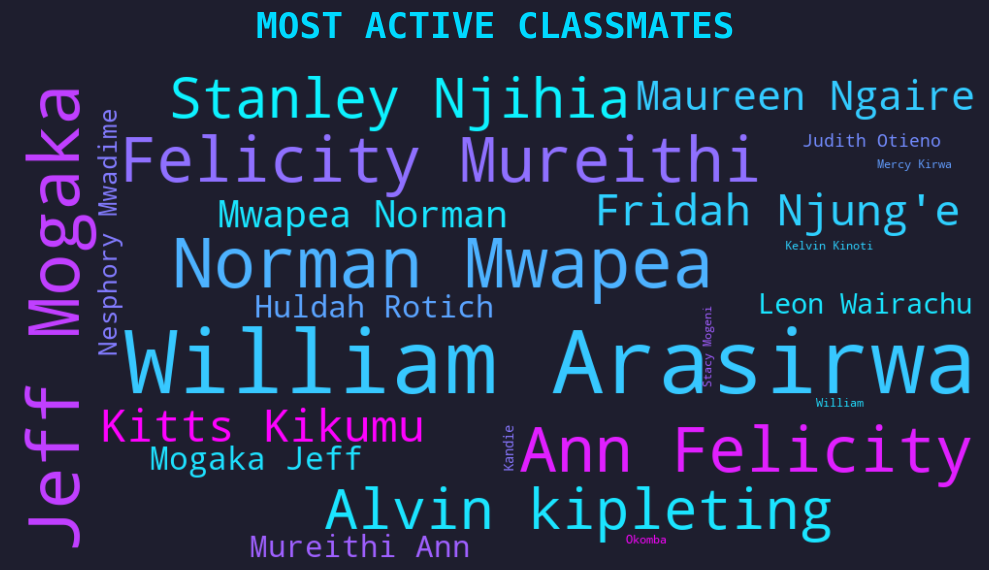

In [65]:
# Combine NLTK stopwords with default WordCloud stopwords
stopwords = set(STOPWORDS).union(set(nltk_stopwords.words('english')))

# Combine all names into a single string (drop NaNs just in case)
text = " ".join(chatterbox_df['name'].dropna().astype(str))

# Create word cloud
wordcloud = WordCloud(
    width=1000,
    height=500,
    background_color='#1e1e2e',
    colormap='cool',
    stopwords=stopwords,
    contour_width=2,
    contour_color='#00d9ff',
    prefer_horizontal=0.65,
    max_words=50,
    relative_scaling=0.5,
    min_font_size=12,
    mode='RGBA'
).generate(text)

# Create figure
fig, ax = plt.subplots(figsize=(10, 7), facecolor='#1e1e2e')
ax.set_facecolor('#1e1e2e')

# Display word cloud
ax.imshow(wordcloud, interpolation='bilinear')
ax.axis('off')

# Add data science themed header
ax.text(
    0.5, 1.08, 'MOST ACTIVE CLASSMATES',
    transform=ax.transAxes,
    fontsize=26,
    weight='bold',
    ha='center',
    color='#00d9ff',
    fontfamily='monospace'
)

plt.tight_layout()
plt.subplots_adjust(top=0.92, bottom=0.05)
plt.show()


          Participant  Number of Messages
     William Arasirwa                 163
          Jeff Mogaka                  98
        Norman Mwapea                  94
Ann-Felicity Mureithi                  79
      Alvin kipleting                  65
       Stanley Njihia                  62
         Kitts Kikumu                  41
       Fridah Njung'e                  40
       Maureen Ngaire                  35
        Huldah Rotich                  22
        Leon Wairachu                  17
     Nesphory Mwadime                  14
        Judith Otieno                   5
          Jeff Kandie                   3
          Mercy Kirwa                   2
         Stacy Mogeni                   2
       William Okomba                   2
        Kelvin Kinoti                   2


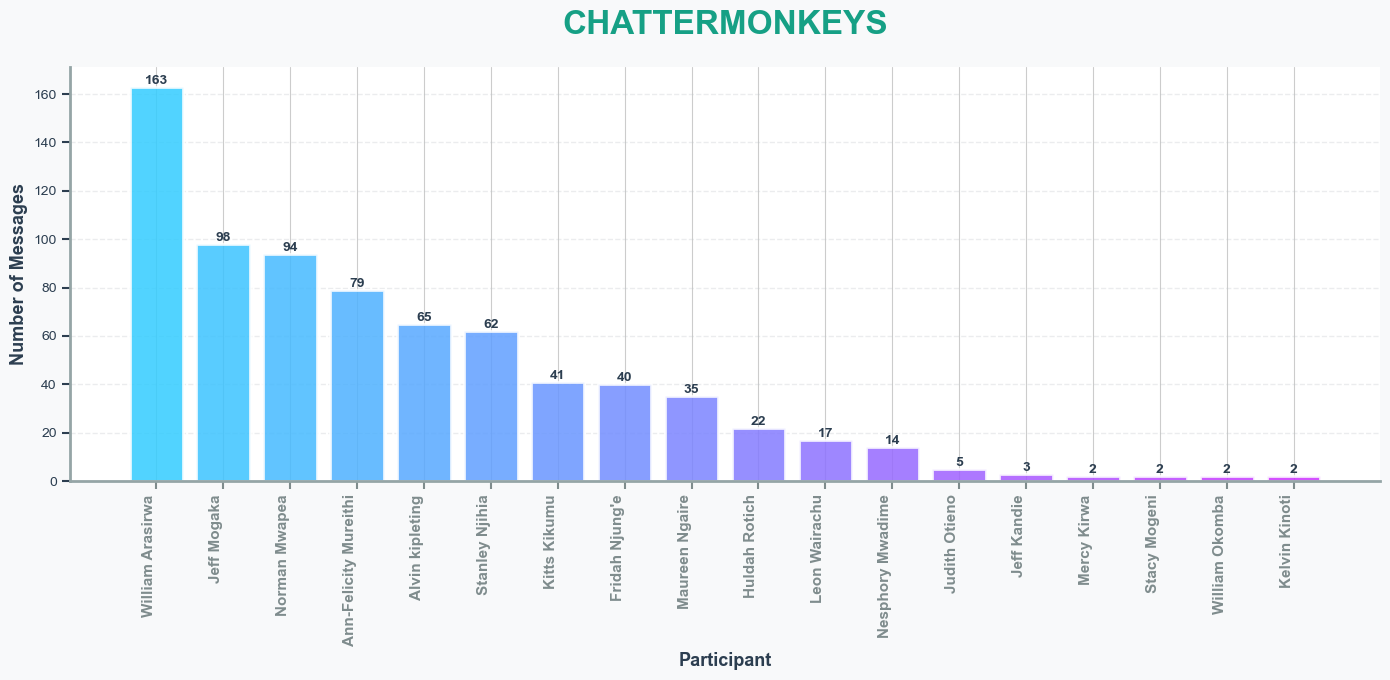

In [66]:
# Get name value counts
name_counts = chatterbox_df['name'].value_counts()

# Save the counts into a dataframe and print them out
df_name_counts = name_counts.reset_index()
df_name_counts.columns = ['Participant', 'Number of Messages']
print(df_name_counts.to_string(index=False))

# Create figure with light theme
fig, ax = plt.subplots(figsize=(14, 7), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Palette
colors = plt.cm.cool(np.linspace(0.2, 0.8, len(name_counts)))

# Create bars 
bars = ax.bar(range(len(name_counts)), name_counts.values, 
               color=colors, 
               edgecolor='white', 
               linewidth=2,
               alpha=0.85)

# Add value labels on top of bars
for i, (bar, value) in enumerate(zip(bars, name_counts.values)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(value)}',
            ha='center', va='bottom',
            color='#2c3e50', fontsize=10, weight='bold')

# Styling
ax.set_xticks(range(len(name_counts)))
ax.set_xticklabels(name_counts.index, rotation=90, ha='right', color='#34495e', fontsize=11, weight='bold')
ax.set_ylabel("Number of Messages", color='#2c3e50', fontsize=13, weight='bold')
ax.set_xlabel("Participant", color='#2c3e50', fontsize=13, weight='bold')

# Grid 
ax.grid(axis='y', alpha=0.3, linestyle='--', color='#bdc3c7', linewidth=1)
ax.set_axisbelow(True)

# Spine styling
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
    
for spine in ['bottom', 'left']:
    ax.spines[spine].set_color('#95a5a6')
    ax.spines[spine].set_linewidth(2)

# Tick styling
ax.tick_params(colors='#7f8c8d', which='both', length=6, width=1.5)
ax.tick_params(axis='y', labelsize=10, colors='#2c3e50')

# Modern title with accent color
ax.text(0.5, 1.08, 'CHATTERMONKEYS', 
        transform=ax.transAxes,
        fontsize=24, 
        weight='bold',
        ha='center',
        color='#16a085',
        fontfamily='sans-serif')

plt.tight_layout()
plt.show()

*Observation:*

- William Arasirwa dominates the conversation with 163 messages, followed by Jeff Mogaka (98) and Norman Mwapea (myself) (94). Together, we account for a large chunk of the activity.
- Ann-Felicity Mureithi (my dear) (79), Alvin Kipleting (65), and Stanley Njihia (62) participate regularly but less intensely than the top three.
- Several students (Judith Otieno, Jeff Kandie, Mercy Kirwa, Stacy Mogeni, William Okomba, Kelvin Kinoti) have very few messages, some just 2–5, indicating minimal participation.

#### 2. day

CHAT ACTIVITY DISTRIBUTION BY DAY

      Day  Message Count  Percentage
  Tuesday            269       36.06
Wednesday            257       34.45
 Thursday            220       29.49




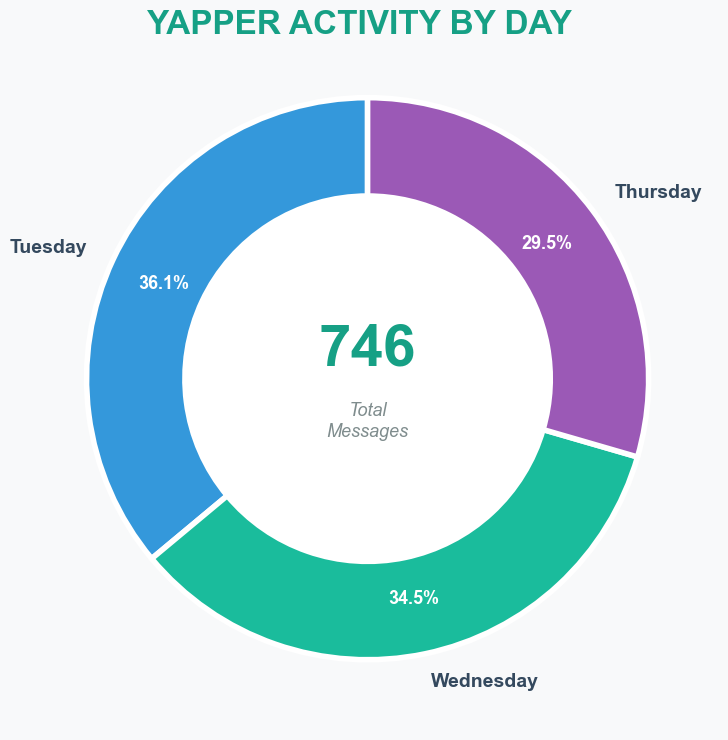

In [67]:
day_counts = chatterbox_df['day'].value_counts()

# Create a dataframe from day_counts
day_distribution = pd.DataFrame({
    'Day': day_counts.index,
    'Message Count': day_counts.values,
    'Percentage': (day_counts.values / day_counts.sum() * 100).round(2)
})

day_distribution = pd.concat([day_distribution], ignore_index=True)

# Display the dataframe
print("CHAT ACTIVITY DISTRIBUTION BY DAY\n")
print(day_distribution.to_string(index=False))
print("\n")

# Create figure with light theme
fig, ax = plt.subplots(figsize=(7.5, 7.5), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Light modern palette - soft blues, teals, and purples
light_colors = ['#3498db', '#1abc9c', '#9b59b6', '#e74c3c', '#f39c12', '#16a085', '#2ecc71']
colors = light_colors[:len(day_counts)]

# Create donut chart 
wedges, texts, autotexts = ax.pie(
    day_counts.values,
    labels=day_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.35, edgecolor='white', linewidth=4),  
    textprops={'color': '#2c3e50', 'fontsize': 13, 'weight': 'bold'},
    pctdistance=0.80
)

# Style percentage labels
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize=11
    autotext.set_weight('bold')

# Style day labels
for text in texts:
    text.set_color('#34495e')
    text.set_fontsize(14)
    text.set_weight('bold')

# Add center circle for donut effect
centre_circle = plt.Circle((0, 0), 0.65, fc='#ffffff', linewidth=0)
ax.add_artist(centre_circle)

# Add center text with light theme colors
total_messages = day_counts.sum()
ax.text(0, 0.1, f'{total_messages}', 
        ha='center', va='center',
        fontsize=42, weight='bold', color='#16a085')
ax.text(0, -0.15, 'Total\nMessages', 
        ha='center', va='center',
        fontsize=13, color='#7f8c8d', style='italic')

# Title with modern styling
fig.text(0.5, 0.96, 'YAPPER ACTIVITY BY DAY', 
         ha='center',
         fontsize=24, 
         weight='bold',
         color='#16a085',
         fontfamily='sans-serif')

plt.tight_layout()
plt.show()

*Observation:*

- Tuesday is the busiest day with 36% of messages, followed closely by Wednesday (34%).
- Thursday sees slightly less activity (29%), but still substantial.

#### 3. hours_in_class

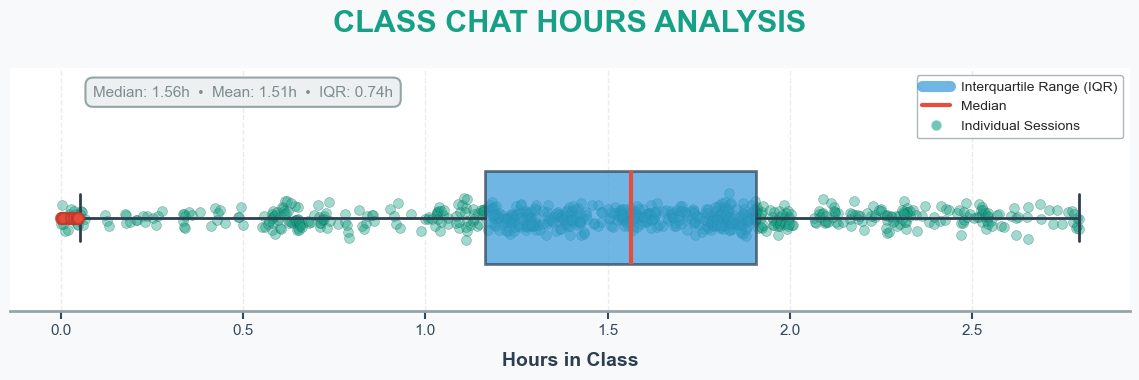

In [68]:
# Create figure
fig, ax = plt.subplots(figsize=(11.5, 4), facecolor='#f8f9fa')
ax.set_facecolor('#ffffff')

# Create boxplot
box = ax.boxplot(chatterbox_df['hours_in_class'], 
                 vert=False,
                 patch_artist=True,
                 widths=0.5,
                 boxprops=dict(facecolor='#3498db', alpha=0.7, edgecolor='#2c3e50', linewidth=2),
                 whiskerprops=dict(color='#2c3e50', linewidth=2),
                 capprops=dict(color='#2c3e50', linewidth=2),
                 medianprops=dict(color='#e74c3c', linewidth=3),
                 flierprops=dict(marker='o', markerfacecolor='#e74c3c', markersize=8, 
                                markeredgecolor='#c0392b', markeredgewidth=1.5, alpha=0.7))

# Add swarm plot overlay for individual data points
y_positions = np.random.normal(1, 0.04, size=len(chatterbox_df))
ax.scatter(chatterbox_df['hours_in_class'], y_positions, 
           alpha=0.4, s=50, color='#16a085', edgecolor='#0e6655', linewidth=0.5,
           zorder=1)

# Calculate statistics
q1 = chatterbox_df['hours_in_class'].quantile(0.25)
q3 = chatterbox_df['hours_in_class'].quantile(0.75)
median = chatterbox_df['hours_in_class'].median()
mean = chatterbox_df['hours_in_class'].mean()
iqr = q3 - q1

# Add statistical annotations
stats_text = f"Median: {median:.2f}h  •  Mean: {mean:.2f}h  •  IQR: {iqr:.2f}h"
ax.text(0.5, 1.65, stats_text,
        transform=ax.transData,
        ha='center',
        fontsize=11,
        color='#7f8c8d',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#ecf0f1', 
                 edgecolor='#95a5a6', linewidth=1.5))

# Styling
ax.set_xlabel("Hours in Class", color='#2c3e50', fontsize=14, weight='bold', labelpad=10)
ax.set_yticks([])
ax.set_ylim(0.5, 1.8)

# Grid
ax.grid(axis='x', alpha=0.3, linestyle='--', color='#bdc3c7', linewidth=1)
ax.set_axisbelow(True)

# Spine styling
for spine in ['top', 'right', 'left']:
    ax.spines[spine].set_visible(False)
    
ax.spines['bottom'].set_color('#95a5a6')
ax.spines['bottom'].set_linewidth(2)

# Tick styling
ax.tick_params(colors='#34495e', which='both', labelsize=11, length=6, width=1.5)

# Title
ax.text(0.5, 1.15, 'CLASS CHAT HOURS ANALYSIS', 
        transform=ax.transAxes,
        fontsize=22, 
        weight='bold',
        ha='center',
        color='#16a085',
        fontfamily='sans-serif')

# Add legend for box plot elements
legend_elements = [
    plt.Line2D([0], [0], color='#3498db', lw=8, alpha=0.7, label='Interquartile Range (IQR)'),
    plt.Line2D([0], [0], color='#e74c3c', lw=3, label='Median'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#16a085', 
               markersize=8, alpha=0.6, label='Individual Sessions')
]
ax.legend(handles=legend_elements, loc='upper right', frameon=True, 
         facecolor='white', edgecolor='#95a5a6', fontsize=10)

plt.tight_layout()
plt.show()

## Step 6: Natural Language Processing (NLP)

This is the heart of this endeavour. 
My focus will be on the text column, as it contains the core of the conversation.

The NLP workflow will follow these steps:
- Convert all text to lowercase.
- Remove punctuation to clean the text.
- Eliminate stop words to focus on meaningful content.
- Tokenize the text into individual words or phrases.

#### Making all texts into lowercase

In [ ]:
# Load Swahili stopwords
stopwords_df = pd.read_csv("swahili_stopwords.csv")
swahili_stopwords = set(stopwords_df.iloc[:, 0].str.strip().str.lower())

# Preprocessing function
def preprocess_text(text, return_tokens=False):
    if pd.isna(text):
        return [] if return_tokens else ""
    # Lowercase
    text = text.lower()
    # Remove non-letters (but keep Swahili characters and spaces)
    text = re.sub(r"[^a-zA-Záéíóúü’ñ\s]", " ", text)
    # Tokenize
    tokens = text.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in swahili_stopwords]
    return tokens if return_tokens else " ".join(tokens)

# Apply preprocessing
# Option A: Cleaned text (string)
chatterbox_df["clean_text"] = chatterbox_df["text"].apply(lambda x: preprocess_text(x, return_tokens=False))

# Option B: Tokenized (list of words)
chatterbox_df["tokens"] = chatterbox_df["text"].apply(lambda x: preprocess_text(x, return_tokens=True))


0                                              lakini i need lessons on presentation
1                                                             mnaskia reverb wakubwa
2                                                                              eeeeh
3      peris, cheza na massgrave io watermark iko apo bottom right iache kukusumbua.
4                                                   address the elephant in the room
                                           ...                                      
741                                                               inakata tu  naisha
742                                                           two months in two days
743                                                       enyewe moringa ni business
744                                                                            eeiyy
745                                      ann ako kwa jungle. mara tunyau. saii jogoo
Name: text, Length: 746, dtype: object

In [70]:
chatterbox_df.columns

Index(['name', 'text', 'day', 'start_time', 'end_time', 'hours_in_class'], dtype='object')